<a href="https://colab.research.google.com/github/E-Daniel-Prada/dysgraphia-detection-crnn/blob/main/dysgraphia_detection_crnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Librerías
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LSTM, Bidirectional, Reshape, Input, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#dimensiones de la imagen de entrada
IMG_HEIGHT, IMG_WIDTH = 128, 128
NUM_CLASSES = 7  # Número de características de disgrafía detectadas
"""
Características:
1. Escritura atípica en relación con el eje vertical, posicion inconsistente o anormal de una letra.
2. Inversiones de los grafemas. Por ejemplo cambiar b por p, entre otras.
3. El tamaño inconsistente de las letras. Este se puede comparar de forma individual o entre palabras
4. Errores ortograficos, a nivel de sintaxis. No se escribe correctamente la palabra.
5. Espaciado atipico en la escritura de palabras y frases.
6. Legibilidad pobre, es decir, no es posible determinar las letras que componen una o varias palabras
7. Palabras abandonadas, es decir, indican "murciela" en vez de "Murcielago"
"""


'\nCaracterísticas:\n1. Escritura atípica en relación con el eje vertical, posicion inconsistente o anormal de una letra.\n2. Inversiones de los grafemas. Por ejemplo cambiar b por p, entre otras.\n3. El tamaño inconsistente de las letras. Este se puede comparar de forma individual o entre palabras\n4. Errores ortograficos, a nivel de sintaxis. No se escribe correctamente la palabra.\n5. Espaciado atipico en la escritura de palabras y frases.\n6. Legibilidad pobre, es decir, no es posible determinar las letras que componen una o varias palabras\n7. Palabras abandonadas, es decir, indican "murciela" en vez de "Murcielago"\n'

In [2]:
from google.colab import drive
import zipfile
import os
import tensorflow as tf

# Montar Google Drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/colab-notebooks/datasets/disgrafia/disgrafia_tags/dataset_disgrafia.zip"
extract_path = "/content/drive/MyDrive/colab-notebooks/datasets/disgrafia/disgrafia_crnn"
# Extraer el ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

for class_folder in os.listdir(extract_path):
    class_path = os.path.join(extract_path, class_folder)
    if os.path.isdir(class_path):
        print(f"{class_folder}: {len(os.listdir(class_path))} imágenes")

Low Potential Dysgraphia: 135 imágenes
Potential Dysgraphia: 114 imágenes


In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Parámetros de configuración
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 42

# Cargar dataset dividiendo en entrenamiento (80%) y validación (20%)
train_dataset = image_dataset_from_directory(
    extract_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = image_dataset_from_directory(
    extract_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 249 files belonging to 2 classes.
Using 200 files for training.
Found 249 files belonging to 2 classes.
Using 49 files for validation.


In [9]:
# Obtener clases
class_names = train_dataset.class_names
print(f"Clases detectadas: {class_names}")


Clases detectadas: ['Low Potential Dysgraphia', 'Potential Dysgraphia']


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


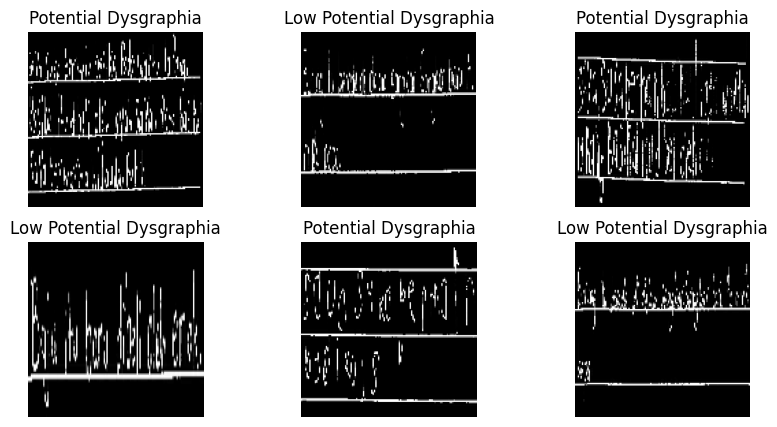

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [17]:
def build_crnn(input_shape=(128, 128, 3), num_classes=2):
    model = models.Sequential([
        # Bloque CNN
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Aplanar para LSTM
        layers.Flatten(),
        layers.Dense(256, activation='relu'),  # Ajustar tamaño para LSTM
        layers.Reshape((16, 16)),  # Convertir a secuencia para LSTM

        # Capa Recurrente LSTM
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),

        # Capa completamente conectada
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # 2 clases
    ])

    return model

In [18]:
# Crear el modelo
model = build_crnn()

In [19]:
# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# Resumen del modelo
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 16, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 16, 64)              │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,551,426 (24.99 MB)

 Trainable params: 6,551,426 (24.99 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Entrenar el modelo
EPOCHS = 15

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4968 - loss: 0.7049 - val_accuracy: 0.5306 - val_loss: 0.6808
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5404 - loss: 0.6923 - val_accuracy: 0.6531 - val_loss: 0.6747
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5804 - loss: 0.6757 - val_accuracy: 0.5306 - val_loss: 0.6834
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 920ms/step - accuracy: 0.5272 - loss: 0.6893 - val_accuracy: 0.5306 - val_loss: 0.6721
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 925ms/step - accuracy: 0.5415 - loss: 0.6858 - val_accuracy: 0.5306 - val_loss: 0.6619
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5683 - loss: 0.6781 - val_accuracy: 0.8980 - val_loss: 0.6268
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 999ms/step - accuracy: 0.6673 - loss: 0.6386 - val_accuracy: 0.8163 - val_loss: 0.6320
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 927ms/step - accuracy: 0.6528 - loss: 0.6503 - val_accuracy: 0.8163 - val_loss: 0.59

In [22]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

Text(0.5, 1.0, 'Precisión del modelo')

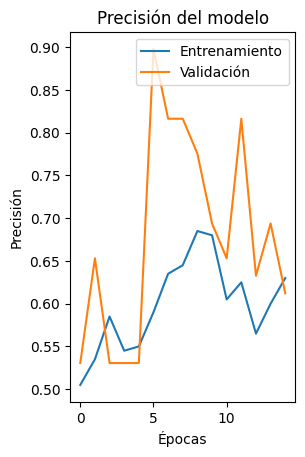

In [23]:
# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.title("Precisión del modelo")

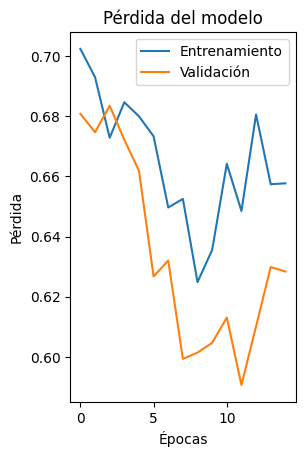

In [25]:
# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.title("Pérdida del modelo")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


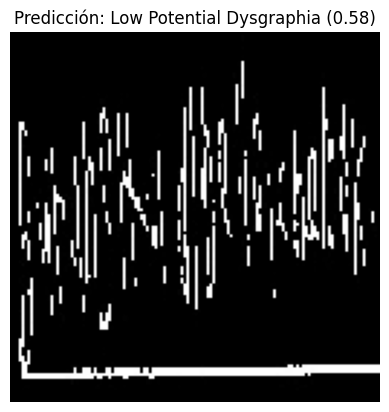

In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Ruta de la imagen de prueba en Google Drive
test_image_path = "/content/drive/MyDrive/colab-notebooks/datasets/disgrafia/disgrafia_crnn/Potential Dysgraphia/PD (4).jpg"  # ⚠️ Cambia esto

# Preprocesar la imagen
img = image.load_img(test_image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Añadir batch dimension
img_array /= 255.0  # Normalizar


# Hacer la predicción
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions)

# Mostrar resultado
plt.imshow(img)
plt.title(f"Predicción: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluar el modelo en datos de validación
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Generar predicciones
y_pred_probs = model.predict(val_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_dataset.classes  # Clases reales

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.class_indices, yticklabels=val_dataset.class_indices)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Reporte de clasificación
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=val_dataset.class_indices))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.6061 - loss: 0.6373
Validation Accuracy: 61.22%
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


AttributeError: '_PrefetchDataset' object has no attribute 'classes'